Importació de llibreries


In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-90519497-ceb0-2bcf-3286-a8918e1af3a6)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
from torch import Tensor
from torch.jit.annotations import List, Tuple


import torchvision.transforms.functional as TF


import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchvision import transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import random
import argparse
import os
import sys
import numpy as np
import numbers
from collections.abc import Sequence

from math import exp
import numpy
import math
import scipy.signal
import scipy.ndimage
import datetime
import time

Definició Classes

In [4]:
# class to extract features for the input image in a different image space like VGG19, AlexNet, DenseNet, etc.
class FeatureExtractor(nn.Module):
    
    def __init__(self, cnn, feature_layer=11):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(cnn.features.children())[:(feature_layer+1)])

    def forward(self, x):
        return self.features(x)

def save_img(x, dir):
    x = x.cpu().numpy().astype(np.float32)
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)
    x = Image.fromarray(x * 255)
    if x.mode != 'RGB':
        x = x.convert('RGB')
    x.save(dir)


def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


class DAC(nn.Module):
    def __init__(self, n_channels):
        super(DAC, self).__init__()

        self.mean = nn.Sequential(
            nn.Conv2d(n_channels, n_channels // 16, 1, 1, 0, 1, 1, False),
            # nn.BatchNorm2d(n_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_channels // 16, n_channels, 1, 1, 0, 1, 1, False),
            # nn.BatchNorm2d(n_channels),
        )
        self.std = nn.Sequential(
            nn.Conv2d(n_channels, n_channels // 16, 1, 1, 0, 1, 1, False),
            # nn.BatchNorm2d(n_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_channels // 16, n_channels, 1, 1, 0, 1, 1, False),
            # nn.BatchNorm2d(n_channels),
        )

    def forward(self, observed_feat, referred_feat):
        assert (observed_feat.size()[:2] == referred_feat.size()[:2])
        size = observed_feat.size()
        referred_mean, referred_std = calc_mean_std(referred_feat)
        observed_mean, observed_std = calc_mean_std(observed_feat)

        normalized_feat = (observed_feat - observed_mean.expand(
            size)) / observed_std.expand(size)
        referred_mean = self.mean(referred_mean)
        referred_std = self.std(referred_std)
        output = normalized_feat * referred_std.expand(size) + referred_mean.expand(size)
        return output


class MSHF(nn.Module):
    def __init__(self, n_channels, kernel=3):
        super(MSHF, self).__init__()

        pad = int((kernel - 1) / 2)

        self.grad_xx = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=pad,
                                 dilation=pad, groups=n_channels, bias=True)
        self.grad_yy = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=pad,
                                 dilation=pad, groups=n_channels, bias=True)
        self.grad_xy = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=pad,
                                 dilation=pad, groups=n_channels, bias=True)

        for m in self.modules():
            if m == self.grad_xx:
                m.weight.data.zero_()
                m.weight.data[:, :, 1, 0] = 1
                m.weight.data[:, :, 1, 1] = -2
                m.weight.data[:, :, 1, -1] = 1
            elif m == self.grad_yy:
                m.weight.data.zero_()
                m.weight.data[:, :, 0, 1] = 1
                m.weight.data[:, :, 1, 1] = -2
                m.weight.data[:, :, -1, 1] = 1
            elif m == self.grad_xy:
                m.weight.data.zero_()
                m.weight.data[:, :, 0, 0] = 1
                m.weight.data[:, :, 0, -1] = -1
                m.weight.data[:, :, -1, 0] = -1
                m.weight.data[:, :, -1, -1] = 1

        # # Freeze the MeanShift layer
        # for params in self.parameters():
        #     params.requires_grad = False

    def forward(self, x):
        fxx = self.grad_xx(x)
        fyy = self.grad_yy(x)
        fxy = self.grad_xy(x)
        hessian = ((fxx + fyy) + ((fxx - fyy) ** 2 + 4 * (fxy ** 2)) ** 0.5) / 2
        return hessian


class rcab_block(nn.Module):
    def __init__(self, n_channels, kernel, bias=False, activation=nn.ReLU(inplace=True)):
        super(rcab_block, self).__init__()

        block = []

        block.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel, padding=1, bias=bias))
        block.append(activation)
        block.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel, padding=1, bias=bias))

        self.block = nn.Sequential(*block)

        self.calayer = nn.Sequential(
            nn.Conv2d(n_channels, n_channels // 16, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_channels // 16, n_channels, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        residue = self.block(x)
        chnlatt = F.adaptive_avg_pool2d(residue, 1)
        chnlatt = self.calayer(chnlatt)
        output = x + residue * chnlatt

        return output


class DiEnDec(nn.Module):
    def __init__(self, n_channels, act=nn.ReLU(inplace=True)):
        super(DiEnDec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, n_channels * 2, kernel_size=3, padding=1, dilation=1, bias=True),
            act,
            nn.Conv2d(n_channels * 2, n_channels * 4, kernel_size=3, padding=2, dilation=2, bias=True),
            act,
            nn.Conv2d(n_channels * 4, n_channels * 8, kernel_size=3, padding=4, dilation=4, bias=True),
            act,
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, kernel_size=3, padding=4, dilation=4, bias=True),
            act,
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, kernel_size=3, padding=2, dilation=2, bias=True),
            act,
            nn.ConvTranspose2d(n_channels * 2, n_channels, kernel_size=3, padding=1, dilation=1, bias=True),
            act,
        )
        self.gate = nn.Conv2d(in_channels=n_channels, out_channels=1, kernel_size=1)

    def forward(self, x):
        output = self.gate(self.decoder(self.encoder(x)))
        return output


class SingleModule(nn.Module):
    def __init__(self, n_channels, n_blocks, act, attention):
        super(SingleModule, self).__init__()
        res_blocks = [rcab_block(n_channels=n_channels, kernel=3, activation=act) for _ in range(n_blocks)]
        self.body_block = nn.Sequential(*res_blocks)
        self.attention = attention
        if attention:
            self.coder = nn.Sequential(DiEnDec(3, act))
            self.dac = nn.Sequential(DAC(n_channels))
            self.hessian3 = nn.Sequential(MSHF(n_channels, kernel=3))
            self.hessian5 = nn.Sequential(MSHF(n_channels, kernel=5))
            self.hessian7 = nn.Sequential(MSHF(n_channels, kernel=7))

    def forward(self, x):
        sz = x.size()
        resin = self.body_block(x)

        if self.attention:
            hessian3 = self.hessian3(resin)
            hessian5 = self.hessian5(resin)
            hessian7 = self.hessian7(resin)
            hessian = torch.cat((torch.mean(hessian3, dim=1, keepdim=True),
                                 torch.mean(hessian5, dim=1, keepdim=True),
                                 torch.mean(hessian7, dim=1, keepdim=True))
                                , 1)
            hessian = self.coder(hessian)
            attention = torch.sigmoid(self.dac[0](hessian.expand(sz), x))
            resout = resin * attention
        else:
            resout = resin

        output = resout + x

        return output


class Generator(nn.Module):
    def __init__(self, n_channels, n_blocks, n_modules, act=nn.ReLU(True), attention=True, scale=(2, 3, 4)):
        super(Generator, self).__init__()
        self.n_modules = n_modules
        self.input = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=3, stride=1, padding=1, bias=True)
        if n_modules == 1:
            self.body = nn.Sequential(SingleModule(n_channels, n_blocks, act, attention))
        else:
            self.body = nn.Sequential(*[SingleModule(n_channels, n_blocks, act, attention) for _ in range(n_modules)])

        self.tail = nn.Conv2d(n_channels, n_channels, 3, 1, 1, bias=True)

        self.upscale = nn.ModuleList([UpScale(n_channels=n_channels, scale=s, act=False) for s in scale])

        self.output = nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):

        body_input = self.input(x)
        body_output = self.body(body_input)
        if self.n_modules == 1:
            sr_high = self.upscale[0](body_output)
        else:
            sr_high = self.upscale[0](self.tail(body_output) + body_input)
        results = self.output(sr_high)

        return results


class UpScale(nn.Sequential):
    def __init__(self, n_channels, scale, bn=False, act=nn.ReLU(inplace=True), bias=False):
        layers = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(math.log(scale, 2))):
                layers.append(nn.Conv2d(in_channels=n_channels, out_channels=4 * n_channels, kernel_size=3, stride=1,
                                        padding=1, bias=bias))
                layers.append(nn.PixelShuffle(2))
                if bn: layers.append(nn.BatchNorm2d(n_channels))
                if act: layers.append(act)
        elif scale == 3:
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=9 * n_channels, kernel_size=3, stride=1,
                                    padding=1, bias=bias))
            layers.append(nn.PixelShuffle(3))
            if bn: layers.append(nn.BatchNorm2d(n_channels))
            if act: layers.append(act)
        else:
            raise NotImplementedError

        super(UpScale, self).__init__(*layers)

# discriminator class definition    
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
      
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(64, 64, 3, stride=2, padding=1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(64, 128, 3, stride=1, padding=1))
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(128, 128, 3, stride=2, padding=1))
        self.conv5 = nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, stride=1, padding=1))
        self.conv6 = nn.utils.spectral_norm(nn.Conv2d(256, 256, 3, stride=2, padding=1))
        self.conv7 = nn.utils.spectral_norm(nn.Conv2d(256, 512, 3, stride=1, padding=1))
        self.conv8 = nn.utils.spectral_norm(nn.Conv2d(512, 512, 3, stride=2, padding=1))

        self.conv9 = nn.Conv2d(512, 1, 1, stride=1, padding=1)
        
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))

        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.leakyrelu(self.conv4(x))
        x = self.leakyrelu(self.conv5(x))
        x = self.leakyrelu(self.conv6(x))
        x = self.leakyrelu(self.conv7(x))
        x = self.leakyrelu(self.conv8(x))

        x = self.conv9(x)
        return F.avg_pool2d(x, x.size()[2:])#.view(x.size()[0], -1), F.avg_pool2d(x, x.size()[2:])

# class to visualize results    
class Visualizer:
    
    def __init__(self, show_step=100, image_size=30):
        self.transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2)),
                                            transforms.ToPILImage(),
                                            transforms.Resize(image_size)])

        self.show_step = show_step
        self.step = 0

        self.figure, (self.lr_plot, self.hr_plot, self.fake_plot) = plt.subplots(1,3)
        self.figure.show()

        self.lr_image_ph = None
        self.hr_image_ph = None
        self.fake_hr_image_ph = None

    def show(self, inputsG, inputsD_real, inputsD_fake):

        self.step += 1
        
        if self.step == self.show_step:
            i = random.randint(0, inputsG.size(0) -1)

            lr_image = self.transform(inputsG[i])
            hr_image = self.transform(inputsD_real[i])
            fake_hr_image = self.transform(inputsD_fake[i])

            if self.lr_image_ph is None:
                self.lr_image_ph = self.lr_plot.imshow(lr_image)
                self.hr_image_ph = self.hr_plot.imshow(hr_image)
                self.fake_hr_image_ph = self.fake_plot.imshow(fake_hr_image)
            else:
                self.lr_image_ph.set_data(lr_image)
                self.hr_image_ph.set_data(hr_image)
                self.fake_hr_image_ph.set_data(fake_hr_image)

            self.figure.canvas.draw()
            plt.pause(0.001)
            
            self.step = 0
            self.figure, (self.lr_plot, self.hr_plot, self.fake_plot) = plt.subplots(1,3)
            self.lr_image_ph = None
            self.hr_image_ph = None
            self.fake_hr_image_ph = None


Mètriques


In [5]:
# Image quality metrics

# 1. SSIM - Structural Similarity Metric
from math import exp
  
# from piqa import ssim

# class SSIM(ssim.SSIM):
#     def forward(self, x, y):
#         return 1. - super().forward(x, y)

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        
        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


# 2. VIFP - Visual Information Fidelity Measure 
def vifp_measure(ref, dist):
  
    ref = ref.cpu().detach().numpy()
    dist = dist.cpu().detach().numpy()
    sigma_nsq=2
    eps = 1e-10

    num = 0.0
    den = 0.0
    for scale in range(1, 5):
       
        N = 2**(4-scale+1) + 1
        sd = N/5.0

        if (scale > 1):
            ref = scipy.ndimage.gaussian_filter(ref, sd)
            dist = scipy.ndimage.gaussian_filter(dist, sd)
            ref = ref[::2, ::2]
            dist = dist[::2, ::2]
                
        mu1 = scipy.ndimage.gaussian_filter(ref, sd)
        mu2 = scipy.ndimage.gaussian_filter(dist, sd)
        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2
        sigma1_sq = scipy.ndimage.gaussian_filter(ref * ref, sd) - mu1_sq
        sigma2_sq = scipy.ndimage.gaussian_filter(dist * dist, sd) - mu2_sq
        sigma12 = scipy.ndimage.gaussian_filter(ref * dist, sd) - mu1_mu2
        
        sigma1_sq[sigma1_sq<0] = 0
        sigma2_sq[sigma2_sq<0] = 0
        
        g = sigma12 / (sigma1_sq + eps)
        sv_sq = sigma2_sq - g * sigma12
        
        g[sigma1_sq<eps] = 0
        sv_sq[sigma1_sq<eps] = sigma2_sq[sigma1_sq<eps]
        sigma1_sq[sigma1_sq<eps] = 0
        
        g[sigma2_sq<eps] = 0
        sv_sq[sigma2_sq<eps] = 0
        
        sv_sq[g<0] = sigma2_sq[g<0]
        g[g<0] = 0
        sv_sq[sv_sq<=eps] = eps
        
        num += numpy.sum(numpy.log10(1 + g * g * sigma1_sq / (sv_sq + sigma_nsq)))
        den += numpy.sum(numpy.log10(1 + sigma1_sq / sigma_nsq))
        
    vifp = num/den


    return vifp  


In [6]:
import torchvision.transforms.functional_pil as F_pil
import torchvision.transforms.functional_tensor as F_t

from torchvision.transforms.functional import crop, center_crop


def sixtenn_crop_custom(img: Tensor, size: List[int], border: List[int]) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:

    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    elif isinstance(size, (tuple, list)) and len(size) == 1:
        size = (size[0], size[0])

    if len(size) != 2:
        raise ValueError("Please provide only two dimensions (h, w) for size.")

    if isinstance(border, numbers.Number):
        border = (int(border), int(border))
    elif isinstance(border, (tuple, list)) and len(border) == 1:
        border = (border[0], border[0])

    if len(border) != 2:
        raise ValueError("Please provide only two dimensions (h, w) for size.")

    image_width, image_height = _get_image_size(img)
    crop_height, crop_width = size
    border_height, border_width = border

    if crop_width > image_width or crop_height > image_height:
        msg = "Requested crop size {} is bigger than input size {}"
        raise ValueError(msg.format(size, (image_height, image_width)))

    tl1 = crop(img, 0, 0, crop_height + border_height, crop_width + border_width)
    tl2 = crop(img, 0, image_width - crop_width*3 - border_width/2, crop_height + border_height, crop_width + border_width)
    tl3 = crop(img, image_height - crop_height*3 - border_height/2, 0, crop_height + border_height, crop_width + border_width)
    tl4 = crop(img, image_height - crop_height*3 - border_height/2, image_width - crop_width*3 - border_width/2, crop_height + border_height, crop_width + border_width)

    tr1 = crop(img, 0, image_width - crop_width*2 - border_width/2, crop_height + border_height, crop_width + border_width )
    tr2 = crop(img, 0, image_width - crop_width - border_width, crop_height + border_height, crop_width + border_width)
    tr3 = crop(img, image_height - crop_height*3 - border_height/2, image_width - crop_width*2 - border_width/2, crop_height + border_height, crop_width + border_width)
    tr4 = crop(img, image_height - crop_height*3 - border_height/2, image_width - crop_width - border_width, crop_height + border_height, crop_width + border_width)

    bl1 = crop(img, image_height - crop_height*2 - border_height/2, 0, crop_height + border_height, crop_width + border_width)
    bl2 = crop(img, image_height - crop_height*2 - border_height/2, image_width - crop_width*3 - border_width/2, crop_height + border_height, crop_width + border_width)
    bl3 = crop(img, image_height - crop_height - border_height, 0, crop_height + border_height, crop_width + border_width)
    bl4 = crop(img, image_height - crop_height - border_height, image_width - crop_width*3 - border_width/2, crop_height + border_height, crop_width + border_width)

    br1 = crop(img, image_height - crop_height*2 - border_height/2, image_width - crop_width*2 - border_width/2, crop_height + border_height, crop_width + border_width)
    br2 = crop(img, image_height - crop_height*2 - border_height/2, image_width - crop_width - border_width, crop_height + border_height, crop_width + border_width)
    br3 = crop(img, image_height - crop_height - border_height, image_width - crop_width*2 - border_width/2, crop_height + border_height, crop_width + border_width)
    br4 = crop(img, image_height - crop_height - border_height, image_width - crop_width - border_width, crop_height + border_height, crop_width + border_width)

    # center = center_crop(img, [crop_height + border_height, crop_width + crop_width])

    return tl1,tl2,tl3,tl4, tr1,tr2,tr3,tr4, bl1,bl2,bl3,bl4, br1,br2,br3,br4 

class Sixteen_custom(torch.nn.Module):


    def __init__(self, size, border):
        super().__init__()
        self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")
        self.border = _setup_size(border, error_msg="Please provide only two dimensions (h, w) for size.")

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped.

        Returns:
            tuple of 5 images. Image can be PIL Image or Tensor
        """
        return sixtenn_crop_custom(img, self.size,self.border)


    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)



def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)

    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)

    return size

def _get_image_size(img: Tensor) -> List[int]:
    """Returns image sizea as (w, h)
    """
    if isinstance(img, torch.Tensor):
        return F_t._get_image_size(img)

    return F_pil._get_image_size(img)

Prova Carrega Imàgens

In [7]:
from os import listdir
from os.path import isfile, join
from PIL import Image
from IPython.display import display

dataset = 'TrainingSet'
dataroot = './drive/MyDrive/Datasets/SuperResolution/TrainingSet'
subfolder="Set/600px"

dataroot_real = './drive/MyDrive/Datasets/SuperResolution/TrainingSet_Real'

# onlyfiles = [f for f in listdir(join(dataroot,subfolder)) if isfile(join(join(dataroot,subfolder), f))]
# pil_im = Image.open(join(join(dataroot,subfolder),onlyfiles[0]))

# # onlyfiles = [f for f in listdir(dataroot) if isfile(join(dataroot, f))]
# # pil_im = Image.open(join(dataroot,onlyfiles[0]))


# display(pil_im)
# print(len(onlyfiles))
# print(pil_im.size)

Entrenament - Carrega Dades


In [8]:
"""
Training the model

"""


workers = 1
batchSize = 1
# imageSize_w = 150
# imageSize_h = 300
imageSize_w = 150
imageSize_h = 150
border= 50
upSampling = 4
factor=4
nEpochs = 2
cuda = True

# generatorWeights = 'generator_final_ep2_13.3154.pth'
# discriminatorWeights = 'discriminator_final_ep2_13.3154.pth'
# experiment='20210317-144607_16parts_defian_mse/models'

out = './drive/MyDrive/checkpoints'

try:
    os.makedirs(out)
except OSError:
    pass

if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device! You should probably set the variable 'cuda=True'")

#transform the data    
# transform = transforms.Compose([transforms.Resize(imageSize),
#                                 transforms.ToTensor()])

normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# transform = transforms.Compose([transforms.Resize(imageSize*2),FiveCrop_custom(imageSize,border),transforms.Lambda(lambda crops: torch.stack([normalize(transforms.ToTensor()(crop)) for crop in crops[0:4]]))])

transform = transforms.Compose([Sixteen_custom([imageSize_h,imageSize_w],border),transforms.Lambda(lambda crops: torch.stack([normalize(transforms.ToTensor()(crop)) for crop in crops]))])


# transforms.Lambda(lambda crops: torch.stack([(transforms.ToTensor()(crop)) for crop in crops]))

# transform_real = transforms.Compose([transforms.Resize(imageSize*upSampling),
#                                 transforms.ToTensor()])

# transform_real = transforms.Compose([transforms.Resize(imageSize*2*upSampling),FiveCrop_custom(imageSize*upSampling,border*upSampling),transforms.Lambda(lambda crops: torch.stack([normalize(transforms.ToTensor()(crop)) for crop in crops[0:4]]))])

# transform_real = transforms.Compose([transforms.Resize(2400,torchvision.transforms.InterpolationMode.BICUBIC),Sixteen_custom([imageSize_h*upSampling,imageSize_w*upSampling],border*upSampling),transforms.Lambda(lambda crops: torch.stack([normalize(transforms.ToTensor()(crop)) for crop in crops]))])
transform_real = transforms.Compose([Sixteen_custom([imageSize_h*upSampling,imageSize_w*upSampling],border*upSampling),transforms.Lambda(lambda crops: torch.stack([normalize(transforms.ToTensor()(crop)) for crop in crops]))])


# transform = transforms.Compose([transforms.ToTensor()])

# transform_real = transforms.Compose([transforms.ToTensor()])



transform_to_save = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2)),
                                            transforms.ToPILImage()])

# transform = transforms.Compose([transforms.ToTensor()])


# # load training data
# if dataset == 'TrainingSet':
#     dataset_train = datasets.ImageFolder(root=dataroot, transform=transform)
#     dataset_train_real = datasets.ImageFolder(root=dataroot_real, transform=transform_real)
#     print("Dataset")
# assert dataset_train

# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize,
#                                          shuffle=False, num_workers=int(workers))

# dataloader_train_real = torch.utils.data.DataLoader(dataset_train_real, batch_size=batchSize,
#                                          shuffle=False, num_workers=int(workers))


# print(dataset_train[0][0].shape)
# print(dataset_train_real[0][0].shape)



Avaluació

Generator model loaded
torch.Size([16, 3, 200, 200])


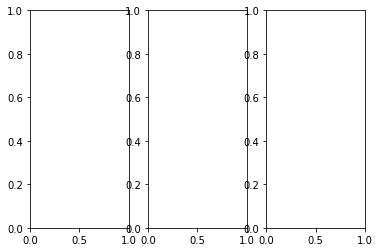

In [9]:
"""
Evaluating the model

"""


generatorWeights = 'generator_final_ep3_13.5665.pth'
# discriminatorWeights = 'discriminator_final_ep1_13.5216.pth'
experiment_test='20210330-172437_16parts_defian_mse/models'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


eval_generator= Generator(64, 20,10, nn.ReLU(True),attention=True, scale=[upSampling ])

# generator.to(device)

# Optional DataParallel, not needed for single GPU usage
# generator1 = torch.nn.DataParallel(generator, device_ids=[0]).to(device)
# Or, using default 'device_ids=None'
# generator1= torch.nn.DataParallel(generator).to(device)

if generatorWeights != '':
    eval_generator.load_state_dict(torch.load(join(out,experiment_test,generatorWeights)))
    # cpk = torch.load((join(out,experiment_test,generatorWeights)), map_location={'cuda:1': 'cuda:0'})["state_dict"]
    # eval_generator.load_state_dict(cpk, strict=False)
    print("Generator model loaded")

# load the trained model
# eval_generator = Generator(16, upSampling)
# eval_generator.load_state_dict(torch.load(join(out,experiment,generatorWeights)))
eval_generator.eval()
# eval_generator.half() 

dataset = 'TestSet'
dataroot_test = './drive/MyDrive/Datasets/SuperResolution/TestSet'



workers = 1
batchSize = 1
cuda = True


if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device! You should probably set the variable 'cuda=True'")

# transform the data   

# Mateixa transformació de dades que en training



# load test data
if dataset == 'TestSet':
    dataset_test = datasets.ImageFolder(root=dataroot_test, transform=transform)
assert dataset

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize,
                                         shuffle=False, num_workers=int(workers))



print(dataset_test[0][0].shape)
# set the visualizer
visualizer = Visualizer(image_size=imageSize_w*upSampling)


In [10]:

print("Model evaluation\n\n")



# use GPU if available
if cuda:
    eval_generator.cuda()

low_res = torch.FloatTensor(batchSize, 3, imageSize_w, imageSize_h)  

  
for i, data in enumerate(dataloader_test):
    
    
    # get data
    # high_res_real, _ = data
    low_res, _ = data
    low_res=torch.squeeze(low_res)
    
    sample_fname, _ = dataloader_test.dataset.samples[i]
    print(sample_fname)
    head, tail = os.path.split(sample_fname)
    final_tail=tail[12:16]
    print(final_tail)

    # downsample images to low resolution
    for j in range(batchSize*16):
        low_res_crop=low_res[j,:,:,:].unsqueeze(0)
        
      # Generate real and fake inputs
        if cuda:
            with torch.cuda.amp.autocast():
            # high_res_real = Variable(high_res_real.cuda())
               high_res_fake_crop = eval_generator(Variable(low_res_crop).cuda())
            
        
        else:
            # high_res_real = Variable(high_res_real)
            high_res_fake = eval_generator(Variable(low_res_crop))
            
        # ssim_val = ssim(high_res_real, high_res_fake)
        # mean_ssim += ssim_val
        
        # vifp = vifp_measure(high_res_real, high_res_fake)
        # mean_vifp += vifp
      
        try:
          os.makedirs(join(out,experiment_test,"save_test"))
          time.sleep(3)
          print("Sleep 3 s")
        except OSError:
          pass

        if j==0:
          image0=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image0=image0.crop((0, 0, imageSize_w*upSampling, imageSize_h*upSampling))
        elif j==1:
          image1=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image1=image1.crop((border*upSampling/2,0, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling))
        elif j==2:
          image2=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image2=image2.crop((0,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))  
          
        elif j==3:
          image3=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image3=image3.crop((border*upSampling/2,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))  
          
        elif j==4:
          image4=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image4=image4.crop((border*upSampling/2,0, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling))
        elif j==5:
          image5=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image5=image5.crop(( border*upSampling,0, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==6:
          image6=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image6=image6.crop(( border*upSampling/2,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==7:
          image7=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image7=image7.crop(( border*upSampling,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))

        if j==8:
          image8=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image8=image8.crop((0, border*upSampling/2, imageSize_w*upSampling++border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==9:
          image9=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image9=image9.crop((border*upSampling/2,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==10:
          image10=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image10=image10.crop((0,border*upSampling, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))  
          
        elif j==11:
          image11=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image11=image11.crop((border*upSampling/2,border*upSampling, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))  
          
        elif j==12:
          image12=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image12=image12.crop((border*upSampling/2,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==13:
          image13=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image13=image13.crop(( border*upSampling,border*upSampling/2, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==14:
          image14=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image14=image14.crop(( border*upSampling/2,border*upSampling, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))
        elif j==15:
          image15=transform_to_save(high_res_fake_crop.cpu().data[0]) 
          image15=image15.crop(( border*upSampling,border*upSampling, imageSize_w*upSampling+border*upSampling, imageSize_h*upSampling+border*upSampling))


          dst = Image.new('RGB', (image0.width * 4, image0.height*4))
          dst.paste(image0, (0 * image0.width, 0))
          dst.paste(image1, (1 * image0.width, 0))
          dst.paste(image2, (0 * image0.width, 1 * image0.height))
          dst.paste(image3, (1 * image0.width, 1 * image0.height))
          
          dst.paste(image4, (2 * image0.width, 0))
          dst.paste(image5, (3 * image0.width, 0))
          dst.paste(image6, (2 * image0.width, 1 * image0.height))
          dst.paste(image7, (3 * image0.width, 1 * image0.height))

          dst.paste(image8, (0 * image0.width, 2 * image0.height))
          dst.paste(image9, (1 * image0.width, 2 * image0.height))
          dst.paste(image10, (0 * image0.width, 3 * image0.height))
          dst.paste(image11, (1 * image0.width, 3 * image0.height))
          
          dst.paste(image12, (2 * image0.width, 2 * image0.height))
          dst.paste(image13, (3 * image0.width, 2 * image0.height))
          dst.paste(image14, (2 * image0.width, 3 * image0.height))
          dst.paste(image15, (3 * image0.width, 3 * image0.height))


          path_save_test=join(out,experiment_test,"save_test","candidate_%s.png" % final_tail,)
          dst.save(path_save_test) 
          print(path_save_test)

    print('\r[%d/%d] ' % ( i+1, len(dataloader_test)))

    # visualizer.show(low_res, high_res_real.cpu().data, high_res_fake.cpu().data)

print("Evaluation ended")    

    # image=transform_to_save(high_res_fake.cpu().data[0]) 
    # image.save(join(out,stamp,"save","prova_%d.png" % i)) 
    
    


Model evaluation


./drive/MyDrive/Datasets/SuperResolution/TestSet/Set/image_600px_0010.png
0010
Sleep 3 s
./drive/MyDrive/checkpoints/20210330-172437_16parts_defian_mse/models/save_test/candidate_0010.png
[1/100] 
./drive/MyDrive/Datasets/SuperResolution/TestSet/Set/image_600px_0030.png
0030
./drive/MyDrive/checkpoints/20210330-172437_16parts_defian_mse/models/save_test/candidate_0030.png
[2/100] 
./drive/MyDrive/Datasets/SuperResolution/TestSet/Set/image_600px_0050.png
0050
./drive/MyDrive/checkpoints/20210330-172437_16parts_defian_mse/models/save_test/candidate_0050.png
[3/100] 
./drive/MyDrive/Datasets/SuperResolution/TestSet/Set/image_600px_0070.png
0070
./drive/MyDrive/checkpoints/20210330-172437_16parts_defian_mse/models/save_test/candidate_0070.png
[4/100] 
./drive/MyDrive/Datasets/SuperResolution/TestSet/Set/image_600px_0090.png
0090
./drive/MyDrive/checkpoints/20210330-172437_16parts_defian_mse/models/save_test/candidate_0090.png
[5/100] 
./drive/MyDrive/Datasets/SuperResolu